(rnn=)
# Recurrent Neural Networks (RNNs)

A Recurrent Neural Network (RNN) is a neural architecture designed for sequential data.
Unlike feedforward networks, it contains *recurrent connections* in the hidden layer: the hidden state $h_t$ at time $t$ depends on both the current input $x_t$ and the previous hidden state $h_{t-1}$. Because the same weights are reused at every step, the model can, in principle, handle sequences of arbitrary length without increasing the parameter count.

### Components of an RNN

1. **Input layer** – receives a sequence of vectors $(x_1,\dots,x_T)$, e.g., word embeddings.
2. **Recurrent (hidden) layer(s)** – update rule below; weights are shared across all $t$.
3. **Output layer** – either emits a prediction $y_t$ at each step, or reads the final state $h_T$ to classify the whole sequence.
4. **Recurrent connection** – the link $h_{t-1}\rightarrow h_t$ that carries memory forward.

### Update Rule
$$
h_t = \sigma(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

$$
y_t = g(W_{hy} h_t + b_y)
$$

where:
* $x_t\in\mathbb{R}^{d_{\text{in}}}$ – input at time $t$.
* $h_t\in\mathbb{R}^{d_h}$ – hidden state (memory).
* $y_t$ – output; in sequence classification we often set $y_t = y$ only for $t=T$.
* $W_{xh}$, $W_{hh}$, $W_{hy}$ and biases $b_h$, $b_y$ – shared, learnable parameters.
* $\sigma$ – typically $\tanh$ or $\text{ReLU}$.
* $g$ – task‑dependent: softmax (language modelling), sigmoid (binary label), or identity (feature for another layer).



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ==========================================================
# 0. Imports and seeds
# ==========================================================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.random.set_seed(1); np.random.seed(1)

# ==========================================================
# 1. Synthetic data: sine wave that changes frequency every 400 steps
#    + a little noise
# ==========================================================
SEQ_LEN       = 50
PRED_HORIZON  = 50      
N_STEPS       = 4_000

def regime_wave(n, switch_every=400, noise=0.05):
    f1, f2 = 0.20, 0.05
    wave   = [np.sin((f1 if (i//switch_every)%2==0 else f2) * i) for i in range(n)]
    return np.array(wave) + noise*np.random.randn(n)

series = regime_wave(N_STEPS)

def make_windows(data, win, horiz):
    X, y = [], []
    for start in range(len(data) - win - horiz):
        X.append(data[start:start+win])
        y.append(data[start+win:start+win+horiz])
    return np.array(X)[..., None], np.array(y)[..., None]

X, y = make_windows(series, SEQ_LEN, PRED_HORIZON)   # (3900, 50, 1)  (3900, 50, 1)

cut            = 2800                                # first 2800 windows for training
X_tr, y_tr     = X[:cut], y[:cut]
X_val, y_val   = X[cut:], y[cut:]
y_tr_vec       = y_tr.squeeze(-1)                    # Dense/Conv need (batch, 50)
y_val_vec      = y_val.squeeze(-1)

# ==========================================================
# 2. Three architectures: Dense, Conv1D, SimpleRNN
# ==========================================================
def dense_model():
    m = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(SEQ_LEN,1)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(PRED_HORIZON)
    ])
    m.compile("adam", "mse")
    return m

def conv_model():
    m = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, 5, activation="relu", input_shape=(SEQ_LEN,1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(PRED_HORIZON)
    ])
    m.compile("adam", "mse")
    return m

def rnn_model():
    m = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=(SEQ_LEN,1)),
        tf.keras.layers.Dense(PRED_HORIZON)
    ])
    m.compile("adam", "mse")
    return m

models = dict(Dense=dense_model(), Conv1D=conv_model(), RNN=rnn_model())
hists  = {}

# ==========================================================
# 3. Train all three
# ==========================================================
for name, mdl in models.items():
    print(f"Training {name:5s}")
    h = mdl.fit(X_tr,
                y_tr_vec if name!="RNN" else y_tr_vec,
                validation_data=(X_val, y_val_vec),
                epochs=40, batch_size=64, verbose=0)
    hists[name] = h.history["val_loss"]
    print(f"   final val MSE: {h.history['val_loss'][-1]:.4f}")

# ==========================================================
# 4. Plot validation loss (log scale)
# ==========================================================
plt.figure(figsize=(6,4))
for name, losses in hists.items():
    plt.plot(losses, label=name)
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("val MSE (log)")
plt.title("SimpleRNN  outperforms Dense & Conv1D")
plt.legend()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-22 10:15:33.268833: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-04-22 10:15:33.268858: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2025-04-22 10:15:33.268861: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
I0000 00:00:1745331333.268873 5204225 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745331333.268894 5204225 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> p

Training Dense


2025-04-22 10:15:33.633813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


   final val MSE: 0.0820
Training Conv1D


KeyboardInterrupt: 

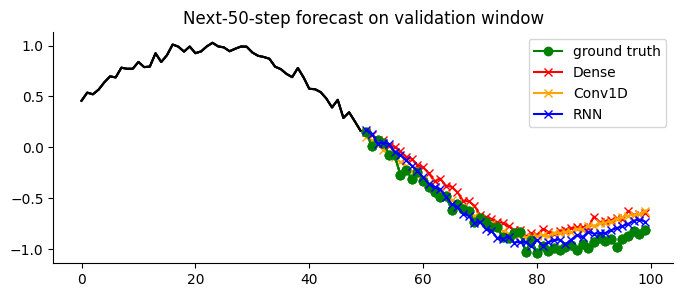

In [104]:
# ==========================================================
# 6. Visualise one forecast window
# ==========================================================
def forecast_trace(model, X_one, y_true, label, color):
    past  = X_one.squeeze()                 # 50‑step context
    truth = y_true.squeeze()                # 50‑step ground truth
    pred  = model.predict(X_one[None, ...], verbose=0).squeeze()

    t_past = np.arange(len(past))
    t_fut  = np.arange(len(past), len(past)+len(truth))

    plt.plot(t_past, past, color="black")
    plt.plot(t_fut, truth, marker="o", color="green",
             label="ground truth" if label=="Dense" else None)
    plt.plot(t_fut, pred,  marker="x", color=color, label=label)

# Pick any validation example
idx = 100
plt.figure(figsize=(8,3))
forecast_trace(models["Dense"],  X_val[idx], y_val[idx], "Dense",  "red")
forecast_trace(models["Conv1D"], X_val[idx], y_val[idx], "Conv1D", "orange")
forecast_trace(models["RNN"],    X_val[idx], y_val[idx], "RNN",    "blue")
plt.title("Next-50-step forecast on validation window")
plt.legend()
sns.despine()
plt.show()


## Example - Sentiment Analysis of Movie Reviews

In [100]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------------- data ----------------
vocab_size = 10_000
maxlen     = 200        # trim / pad reviews to 200 tokens

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen, padding="post")
x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=maxlen, padding="post")

# ---------------- model ----------------
embed_dim    = 64
hidden_units = 32

model = keras.Sequential([
    layers.Embedding(vocab_size, embed_dim, mask_zero=True),  # word → vector
    layers.SimpleRNN(hidden_units),                           # processes the sequence
    layers.Dense(1, activation="sigmoid")                     # one sentiment score
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(x_train, y_train,
          epochs=2,
          batch_size=64,
          validation_split=0.2)

print("Test accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])


Epoch 1/2
313/313 [==============================] - 9s 29ms/step - loss: 0.6079 - accuracy: 0.6524 - val_loss: 0.4933 - val_accuracy: 0.7858
Epoch 2/2
313/313 [==============================] - 9s 29ms/step - loss: 0.3689 - accuracy: 0.8389 - val_loss: 0.4857 - val_accuracy: 0.7608
Test accuracy: 0.764680027961731


In [ ]:
units = 64                          # 4 × 64 = 256 bias values
gate_bias = np.concatenate([
    np.full(units,  2.0),           # input‑gate bias  (open)
    np.full(units,  1.0),           # forget‑gate bias (keep)
    np.zeros(units),                # cell candidate   (neutral)
    np.full(units,  2.0)            # output‑gate bias (open)  ← NEW
]).astype("float32")

good_lstm = Sequential([
    layers.Embedding(2, 4),
    layers.LSTM(
        units,
        unit_forget_bias=False,                 # we initialise all 4 gates ourselves
        bias_initializer=keras.initializers.Constant(gate_bias)
    ),
    layers.Dense(1, activation="sigmoid")
])
good_lstm.compile(
    tf.keras.optimizers.legacy.RMSprop(3e-3, clipnorm=1.0),
    losses.BinaryCrossentropy(),
    ["accuracy"],
)
good_lstm.fit(
    x_tr, y_tr,
    batch_size=256,
    epochs=20,
    validation_split=0.2,
    verbose=2
)
print("LSTM test acc:", good_lstm.evaluate(x_te, y_te, verbose=0)[1])


Epoch 1/20
157/157 - 384s - loss: 0.7047 - accuracy: 0.4970 - val_loss: 0.7075 - val_accuracy: 0.4944 - 384s/epoch - 2s/step
Epoch 2/20


In [ ]:
print("  LSTM:", good_lstm.evaluate(x_te, y_te, verbose=0)[1])
